# Create complete network
- get all layers created so far (grid, roads for cars and bikes, public transport layer(s)) and pre-process them until NetworkX friendly
- Add everything to at NetworkX graph 

In [1]:
import networkx as nx
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import shapely

crs_fr = 4326 #2154 ?
plt.rcParams['figure.figsize'] = (10,10)

In [2]:
# --- From Anastassia
# import packages
%run -i packages.py

# CUSTOM FUNCTION

# define function that creates attribute dictionary for nodes and edges
# (for input to nx.add_edges_from/add_nodes_from)
def make_attr_dict(*args, **kwargs): 
    
    argCount = len(kwargs)
    
    if argCount > 0:
        attributes = {}
        for kwarg in kwargs:
            attributes[kwarg] = kwargs.get(kwarg, None)
        return attributes
    else:
        return None # (if no attributes are given)


## Gather all layers (and pre-process them to make them NetworkX friendly)

### grid, boundary
- only centroids become NetworkX graph 
- have to create an attr_dict with the IRIS number and the geometry of the centroids
- need to create some index or identificator for the individual centroids within an IRIS

In [3]:
# Get boundary of GPM (for plots)

GPM = gpd.read_file('data/raw/GPM_geometry/GPM.geojson').to_crs(crs_fr)

In [4]:
# Get grid and centroids
grid = pd.read_csv('data/processed/GPM_grid.csv').rename(columns = {'geometry' : 'cells'})

# turn into geodataframe and separate centroids (for plots)
for c in ['cells', 'centroid']:
    grid[c] = grid[c].apply(shapely.wkt.loads)
    
grid = gpd.GeoDataFrame(grid, crs = crs_fr, geometry= 'cells' )
centroids = grid.set_geometry('centroid')


In [5]:
## Adapted from Anastassia

# Create a unique number for each centroid
centroids = centroids.reset_index(drop = False).rename(columns = {'index' : 'id'})
centroids['nodetype'] = 'centroid'

# Create attr_dict with geometry and IRIS code
centroids["attr_dict"] = centroids.apply(lambda x: make_attr_dict(geometry = x.centroid,
                                                                  code_iris = x.CODE_IRIS,
                                                                  nodetype = x.nodetype),
                                                                  axis = 1) 

### roads DONE



In [6]:
# Get roads (car and bike)
nodes_all = pd.read_csv("./data/processed/carbike_nodes.csv")
edges_all = pd.read_csv("./data/processed/carbike_edges.csv").drop(columns = 'key')

In [7]:
### Processing: taken from Anastassia's code

# Creating the column "nodetype" 
bike_nodes = set(edges_all.loc[edges_all['edgetype'] == 'bike']['u'])

nodes_all['nodetype'] = 0

for index, row in nodes_all.iterrows():
    if row["osmid"] in bike_nodes:
        nodes_all.loc[index, "nodetype"] = 'bike'
    else:
        nodes_all.loc[index, "nodetype"] = 'car'
           
## Step 1: turn dataframes into geodataframes
# Edges 
edges_all["geometry"] = edges_all.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_all = gpd.GeoDataFrame(edges_all, geometry = "geometry") 

# Nodes
nodes_all["geometry"] = nodes_all.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
nodes_all = gpd.GeoDataFrame(nodes_all, geometry = "geometry")

## Step 2: Sort values and drop duplicates 
nodes_all = nodes_all.sort_values(by = "osmid").reset_index(drop = True) # sort by osmid
# make attribute dictionary with type and geocoordinates for each node
# MOD: removed category_node = x.type 
# MOD: changed coord to geometry
nodes_all["attr_dict"] = nodes_all.apply(lambda x: make_attr_dict(geometry = x.geometry,
                                                                  nodetype = x.nodetype),
                                                                  axis = 1) 

# add edge ids (strings with "id1, id2" sorted (id1 < id2))
edges_all["edge_id"] = edges_all.apply(lambda x: str(sorted([x["u"], x["v"]])), axis = 1)
# (edge ids are set as strings; converting back: with "from ast import literal_eval" fct)
# finding duplicates by ["osmid", "oneway", "edge_id", "length"]
# simplifying network into undirected - beu and ceu contain the "undirected" edges
# (removing all parallel edges)

# MOD: removed oneway and length from the subset
edges_all_unique = edges_all.drop_duplicates(subset = ["osmid", "edge_id"],
                  keep = "first",
                  inplace = False,
                  ignore_index = True).copy()

# remove duplicates
edges_all_unique = edges_all_unique.drop_duplicates(subset = ["u", "v", "osmid", "edge_id", "edgetype"], 
                          keep = "first",
                          ignore_index = True, 
                          inplace = False)

edges_all_unique_tokeep = edges_all_unique[edges_all_unique.duplicated("edge_id", keep = False) & (edges_all_unique["edgetype"]=="bike")].index
edges_all_unique_todrop = edges_all_unique[edges_all_unique.duplicated("edge_id", keep = False) & (edges_all_unique["edgetype"] == "car")].index

# MOD changed "multi" to "both"
edges_all_unique.loc[edges_all_unique_tokeep, "edgetype"] = "both"
edges_all_unique = edges_all_unique.drop(edges_all_unique_todrop)

# add attribute dictionary (for nx)
edges_all_unique["attr_dict"] = edges_all_unique.apply(lambda x: make_attr_dict(edgetype = x.edgetype,
                                                    edge_id = x.edge_id,
                                                    coord = x.geometry,
                                                    intnodes = []), # intnodes attribute: for storing simplification info on interstitial nodes 
                             axis = 1)

# sort by "left" node (id1 < id2 - to control order of tuple keys in nx)
edges_all_unique["order"] = edges_all_unique.apply(lambda x: np.min([x["u"], x["v"]]), axis = 1)
edges_all_unique = edges_all_unique.sort_values(by = "order").reset_index(drop = True)
# MOD: used "x" and "y" insteads of "orgig" and "dest"
edges_all_unique["x"] = edges_all_unique.apply(lambda x: np.min([x["u"], x["v"]]), axis = 1)
edges_all_unique["y"] = edges_all_unique.apply(lambda x: np.max([x["u"], x["v"]]), axis = 1)
edges_all_unique = edges_all_unique.drop(columns = ["order", "u", "v"]) # instead of "u" and "v",
# we will use "origin" and "destination" where osmid(origin) < osmid (destination)!

del(edges_all_unique_todrop, edges_all_unique_tokeep)  

<Axes: >

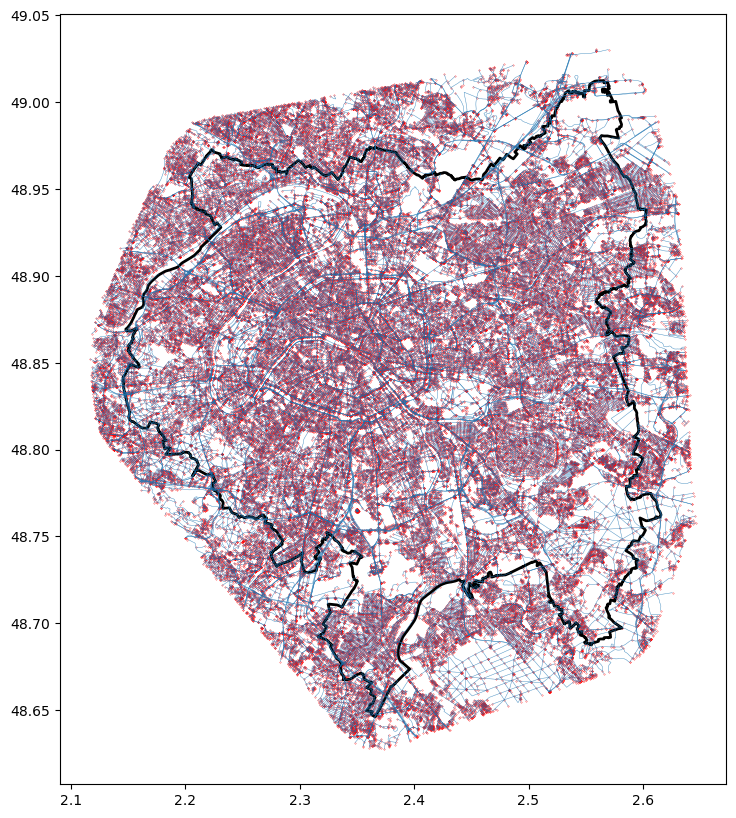

In [8]:
# Plot
ax = plt.axes()
edges_all.plot(ax=ax, linewidth = 0.3, alpha = 0.5)
nodes_all.plot(ax=ax, markersize = 0.05, facecolor = 'red', alpha = 1)
GPM.plot(ax=ax, facecolor = 'none', linewidth = 2)

## Clean up the grid

### OLD IDEAS
- cells with edges within: the centroid is moved to the nearest edge
- cells without edges within: the centroid doesn't move, an edge is added to the nearest neighbor with an edge within

In [9]:
# #--- OLD IDEA

# #Find grid cells with car/bike edges
test_cell_contains_edges = gpd.sjoin(edges_all.set_crs(crs_fr), grid, predicate='intersects')
# cells_with_edges = grid.iloc[test_cell_contains_edges.index_right.unique()] 
# centroid_with_edges = centroids.iloc[test_cell_contains_edges.index_right.unique()].set_crs(crs_fr)

# # plot
# ax = plt.axes()
# cells_with_edges.plot(ax=ax, linewidth = 0.1, alpha = 0.2)
# centroid_with_edges.plot(ax=ax, markersize = 0.1, facecolor = 'red', alpha = 1)
# GPM.plot(ax=ax, facecolor = 'none')

# # TODO move centroids to their nearest neighboring edge in cellsthat contain edges 
# changed_centroids = gpd.sjoin_nearest(centroid_with_edges.to_crs('EPSG:3857'), edges_carbike.to_crs('EPSG:3857'),  how = 'inner', distance_col = 'distance_centroid_node')
# changed_centroids.sort_values(by = 'distance_centroid_node').tail(1) 

# ax = plt.axes()
# changed_centroids.loc[cells_with_edges['CODE_IRIS'] == 930730101].plot(ax=ax, alpha = 0.5)
# edges_carbike.to_crs('EPSG:3857').iloc[[138641]].plot(ax=ax, facecolor = 'red', alpha = 1)
# cells_with_edges.to_crs('EPSG:3857').loc[cells_with_edges['CODE_IRIS'] == 930730101].plot(ax=ax, alpha = 0.5)


### LATEST IDEA
- why not just always add an edge from a centroid to its nearest edge, regardless of whether its within the polygon or not?
- maybe this should be done directly in NetWorkX

<Axes: >

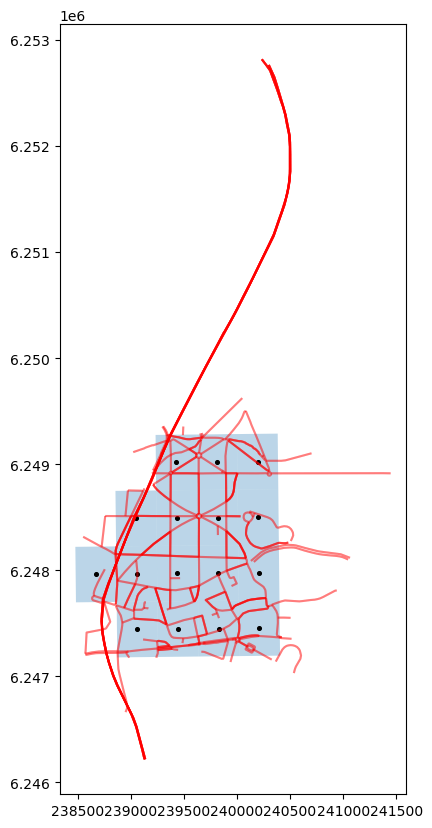

In [10]:
#--- NEW IDEA

# Plot a random IRIS (as its grid and centroids) with its roads for contemplation
# changed crs so the distances are in meters
ax = plt.axes()
grid.to_crs('EPSG:3857').loc[grid['CODE_IRIS'] == 920760101].plot(ax=ax, alpha = 0.3)
centroids.set_crs(crs_fr).to_crs('EPSG:3857').loc[centroids['CODE_IRIS'] == 920760101].plot(ax=ax, facecolor = 'black', markersize = 7)
test_cell_contains_edges.to_crs('EPSG:3857').loc[test_cell_contains_edges['CODE_IRIS'] == 920760101].plot(ax=ax, alpha = 0.3, edgecolor = 'red')

In [11]:
#--- NEW IDEA (continued)

# Need to create bike edge from each centroid to its closest car/bike edge
# wanted to use gpd.distance, but it works on a row-to-row comparison basis
# can be changed to compare all rows of one columns to one specific element. seems like too much
# maybe need to divide by cell (index_right on test_cells_contains_edge)
# => check each centroid individually against all of the roads of its cell
# => pick the one closest to it, add an edge
# for the cells without edges, maybe add an edge to the nearest edge in a neighbroing cell OR to the centroid of the neighboring cell. 

## Combine all layers

For now:
- create NetworkX graph of the roads (DONE without car/bike distinction so far)
- create NetworkX graph of the centroids (completely disconnected nodes) 
- combine CarGraph and CentroidGraph by creating edges from centroids to their closest edge 

In [36]:
# Create NetworkX graph of the roads (Anastassia code)

# CREATE NX OBJECTS
# make multinetwork containing ALL edges
car_bike_graph = nx.Graph()
car_bike_graph.add_nodes_from(nodes_all.loc[:,["osmid", "attr_dict"]].itertuples(index = False))

# MOD: x and y instead of orig and dest
car_bike_graph.add_edges_from(edges_all_unique.loc[:,["x", "y", "attr_dict"]].itertuples(index = False))

# MOD: removed the LCC part

In [37]:
# Create NetworkX graph of the centroids

centroid_graph = nx.Graph()
centroid_graph.add_nodes_from(centroids.loc[:,["id", "attr_dict"]].itertuples(index = False))


In [55]:
# Bringing everything together attempt 1

# test: have everything in one graph
all_layers = nx.Graph()

# Add centroids to the carbike network 
all_layers.add_nodes_from(centroids.loc[:,["id", "attr_dict"]].itertuples(index = False))
all_layers.add_nodes_from(nodes_all.loc[:,["osmid", "attr_dict"]].itertuples(index = False))
all_layers.add_edges_from(edges_all_unique.loc[:,["x", "y", "attr_dict"]].itertuples(index = False))

# subset: centroid nodes in the graph
centroids_in_carbike_graph = [n for n,v in all_layers.nodes(data=True) if v['nodetype'] == 'centroid']
# subset: carbike nodes in the graph
carbike_nodes_from_carbike_graph = [n for n,v in all_layers.nodes(data=True) if v['nodetype'] != 'centroid']
# subset: carbike edges in the graph
carbike_edges_from_carbike_graph = all_layers.edges

# PROBLEM: how do I find the nearest carbike node to a centroid node???

#nx.ego_graph(car_bike_graph, centroids_in_carbike_graph, radius=1, center=True, undirected=False, distance=None)

In [56]:
# Bringing everything together attempt 2
import pymnet
all_layers_2 = pymnet.MultiplexNetwork(couplings=None, directed=False, noEdge=0, fullyInterconnected=False)
all_layers_2.add_layer('centroids')
for i, row in centroids.iterrows():
    all_layers_2.add_node(i)
pymnet.draw(all_layers_2)

TypeError: FigureBase.gca() got an unexpected keyword argument 'projection'

In [14]:
# # Plot all on top of each other (useless)
# ax = plt.axes()
# grid.plot(ax=ax, markersize = 0.1, facecolor = 'green', alpha = 0.5)
# edges_all_unique.plot(ax=ax, linewidth = 0.5, alpha = 0.5)
# nodes_all.plot(ax=ax, markersize = 0.1, facecolor = 'red', alpha = 1)
# GPM.plot(ax=ax, facecolor = 'none', alpha = 1)